In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import math

# Import data from CSV and API

In [2]:
consumption_data = pd.read_csv('consumption_data.csv')
consumption_data.head()

,Date & Time,use [kW]
0,1/1/15 0:00,2.436424
1,1/1/15 1:00,2.582774
2,1/1/15 2:00,1.843835
3,1/1/15 3:00,0.985463
4,1/1/15 4:00,1.497963


API documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/

We will only run the api call once, then save the output to a local file. Afterwards, we only access the data through the local file.

In [3]:
# res_format = "json"
# api_key = "eJDmW1fE7t6rmraylc3TaEk9lJW1s1LSVUwLaHQz"
# system_capacity = 8
# module_type = 0  # standard
# losses = 0
# array_type = 1  # fixed - roof mounted
# tilt = 30
# azimuth = 180
# lat = 42.38061773513459
# lon = -72.53426239911694
# timeframe = "hourly"

In [4]:
# url = f"https://developer.nrel.gov/api/pvwatts/v8.{res_format}?api_key={api_key}&system_capacity={system_capacity}&module_type={module_type}&losses={losses}&array_type={array_type}&tilt={tilt}&azimuth={azimuth}&lat={lat}&lon={lon}&timeframe={timeframe}"

In [5]:
# response = requests.get(url)

In [6]:
# json_object = json.dumps(response.json(), indent=4)
# with open("api_output.json", "w") as outfile:
#   outfile.write(json_object)

In [7]:
# Read json from output file
with open("api_output.json", "r") as openfile:
 
    # Reading from json file
    api_json = json.load(openfile)
 
# print(api_json)
print(type(api_json))

<class 'dict'>


In [8]:
"""
Function that calculate the final amount that the invested portion
of the money becomes after a certain number of years.

Inputs:
  - initial_money: the money that we start with
  - interest_rate: the annual returns rate, as a decimal
  - years: the number of years we want to invest

Output: 
  - a number representing the amount that the money becomes
    after that many years of investment
"""
def invest(initial_money, interest_rate, years):
  final_amount = initial_money * (1 + (interest_rate))**years
  return final_amount

In [9]:
invest(34000, 0.07, 30)

258816.67145050943

In [10]:
# Conversion of pandas column to numpy array
hourly_usage = consumption_data["use [kW]"].to_numpy()
print(hourly_usage[0:5])
print(np.shape(hourly_usage))

[2.43642417 2.58277361 1.84383528 0.98546278 1.4979625 ]
(8760,)


In [11]:
# Conversion of json to numpy array
hourly_generation = np.array(api_json["outputs"]["ac"])
print(hourly_generation[0:5])
print(np.shape(hourly_generation))

[0. 0. 0. 0. 0.]
(8760,)


Note that hourly usage is stored in kWh, while hourly generation is in Watts.

In [12]:
"""
Function that calculates how much it costs to run solar panels
without net metering

Inputs:
  - electricity rate: how much electricity costs per kWh
  - years: how many years we want to calculate
  - battery (optional): if there is a battery in the house or not

Output:
  - total cost for the number of years
"""
def no_net_metering_cost(electricity_rate, years, battery=False, battery_capacity=15):
  battery_charge = 0
  cost_per_year = 0
  battery_history = []

  # This loop calculates the cost of electricity for one year (from data)
  for usage, generation in zip(hourly_usage, hourly_generation):
    excess_usage = usage - (generation/1000)

    # if excess_usage < 0:
      # print(excess_usage)

    # if battery_charge > 0:
    #   print("battery has charge")

    # If there is a battery
    if battery:
      # We generated less energy than we used
      # Check if we can cover excess usage with battery power
      if excess_usage >= 0 and battery_charge > 0:
        # Using up all the battery
        if excess_usage > battery_charge:
          excess_usage -= battery_charge
          battery_charge = 0
        
        # Can completely cover excess usage and have battery left
        else:
          battery_charge -= excess_usage
          excess_usage = 0

      # We generated more energy than we used
      elif excess_usage < 0:
        excess_generation = -excess_usage

        # The excess generated amount exceeds the amount that can be stored in battery
        if battery_charge + excess_generation > battery_capacity:
          excess_generation -= battery_charge + excess_generation - battery_capacity
          battery_charge = battery_capacity
        
        # Battery has enough space to store all excess energy
        else:
          battery_charge += excess_generation
          excess_generation = 0
          
        excess_usage = -excess_generation

      battery_history.append(battery_charge)
      
    # Calculate the cost of the electricity that needs to be pulled from the grid
    if excess_usage > 0:
      cost_per_year += electricity_rate * excess_usage

    # costs.append(cost_per_year)

  # print(battery_history)

  return cost_per_year * years

In [13]:
"""
Function that calculates how much it costs to run solar panels
with retail net metering

Inputs:
  - electricity rate: how much electricity costs per kWh
  - years: how many years we want to calculate
  - battery (optional): if there is a battery in the house or not

Output:
  - total cost for the number of years
"""
def retail_metering_cost(electricity_rate, years, battery=False, battery_capacity=15):
  battery_charge = 0
  cost_per_year = 0
  battery_history = []

  # This loop calculates the cost of electricity for one year (from data)
  for usage, generation in zip(hourly_usage, hourly_generation):
    excess_usage = usage - generation/1000
    # print(excess_usage)

    # Check if we can and need to cover excess usage with battery power
    if battery:
      if excess_usage > 0 and battery_charge > 0:
        # Using up all the battery
        if excess_usage >= battery_charge:
          excess_usage -= battery_charge
          battery_charge = 0
        
        # Can completely cover excess usage and have battery left
        else:
          battery_charge -= excess_usage
          excess_usage = 0

      elif excess_usage < 0:
        excess_generation = -excess_usage

        # The excess generated amount exceeds the amount that can be stored in battery
        if battery_charge + excess_generation > battery_capacity:
          excess_generation -= battery_charge + excess_generation - battery_capacity
          battery_charge = battery_capacity
        
        # Battery has enough space to store all excess energy
        else:
          battery_charge += excess_generation
          excess_generation = 0
          
        excess_usage = -excess_generation
      
      battery_history.append(battery_charge)
    
    # Calculate the cost of the electricity that needs to be pulled from the grid
    # Since excess_usage = -1 * excess_generation, we can use the same formula to 
    # calculate how much money we get refunded for excess generation
    cost_per_year += electricity_rate * excess_usage

  # plt.plot(np.arange(1, len(costs)+1), costs, label="Retail")
  # plt.legend()

  # print(battery_history)

  return cost_per_year * years

In [14]:
"""
Function that calculates how much it costs to run solar panels
with retail net metering

Inputs:
  - electricity rate: how much electricity costs per kWh
  - years: how many years we want to calculate
  - battery (optional): if there is a battery in the house or not

Output:
  - total cost for the number of years
"""
def wholesale_metering_cost(electricity_rate, years, battery=False, battery_capacity=15):
  battery_charge = 0
  cost_per_year = 0
  battery_history = []

  # This loop calculates the cost of electricity for one year (from data)
  for usage, generation in zip(hourly_usage, hourly_generation):
    excess_usage = usage - generation/1000

    # Check if we can and need to cover excess usage with battery power
    if battery:
      if excess_usage > 0 and battery_charge > 0:
        # Using up all the battery
        if excess_usage > battery_charge:
          excess_usage -= battery_charge
          battery_charge = 0
        
        # Can completely cover excess usage and have battery left
        else:
          battery_charge -= excess_usage
          excess_usage = 0

      if excess_usage < 0:
        excess_generation = -excess_usage

        if battery_charge + excess_generation > battery_capacity:
          excess_generation -= battery_charge + excess_generation - battery_capacity
          battery_charge = battery_capacity
        
        else:
          # print("Excess generation:", excess_generation)
          battery_charge += excess_generation
          excess_generation = 0
          
        excess_usage = -excess_generation

      battery_history.append(battery_charge)
    
    # Calculate the cost of the electricity that needs to be pulled from the grid
    if excess_usage > 0:
      cost_per_year += electricity_rate * excess_usage

    # Calculate the refunds for excess generation at wholesale rate
    else:
      excess_generation = -excess_usage
      cost_per_year -= electricity_rate * excess_generation / 2

  # plt.plot(np.arange(1, len(costs)+1), costs, label="Wholesale")
  # plt.legend()
  # print(costs[5:15])
  # print(battery_history)

  # plt.plot(np.arange(0, len(battery_history)), battery_history)

  return cost_per_year * years

In [15]:
invest(34000, 0.07, 30)

258816.67145050943

In [16]:
rate = 0.36
interest = 0.07
years = 30

no_solar_per_year = np.sum(hourly_usage) * rate * years

no_solar_retail = no_solar_per_year - invest(34000, interest, years)
no_solar_wholesale = no_solar_per_year - invest(34000, interest, years)
no_solar_no_metering = no_solar_per_year - invest(34000, interest, years)

solar_retail = retail_metering_cost(rate, years) - invest(8000, interest, years) 
solar_wholesale = wholesale_metering_cost(rate, years) - invest(8000, interest, years)
solar_no_metering = no_net_metering_cost(rate, years) - invest(8000, interest, years)

In [17]:
solar_battery_retail = retail_metering_cost(rate, years, battery=True)
solar_battery_wholesale = wholesale_metering_cost(rate, years, battery=True)
solar_battery_no_metering = no_net_metering_cost(rate, years, battery=True)

In [18]:
# print(solar_no_metering)
# print(solar_battery_no_metering)
# print()

# print(solar_retail)
# print(solar_battery_retail)
# print()

# print(solar_wholesale)
# print(solar_battery_wholesale)

In [19]:
invest(8000, 0.07, 30)

60898.040341296335

In [20]:
np.sum(hourly_usage) * 30

443326.21045875

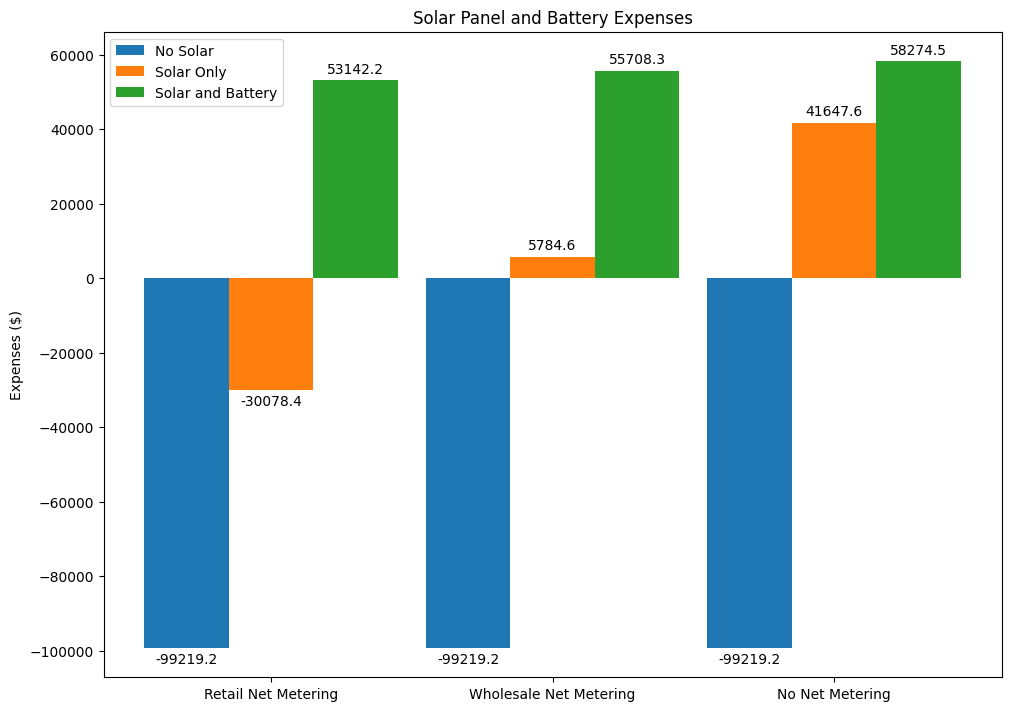

In [21]:
system_type = ("Retail Net Metering", "Wholesale Net Metering", "No Net Metering")
expenses = {
    'No Solar': (no_solar_retail, no_solar_wholesale, no_solar_no_metering),
    'Solar Only': (solar_retail, solar_wholesale, solar_no_metering),
    'Solar and Battery': (solar_battery_retail, solar_battery_wholesale, solar_battery_no_metering),
}

x = np.arange(len(system_type))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,7), layout='constrained')

for attribute, measurement in expenses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expenses ($)')
ax.set_title('Solar Panel and Battery Expenses')
ax.set_xticks(x + width, system_type)
ax.legend(loc='best')
# ax.set_ylim(0, 250)

plt.show()

This graph shows the total expenses of each combination scenario over 30 years, with positive numbers meaning that you are paying that amount, and negative numbers meaning that you are gaining money. For no solar, we are gaining money in every scenario since  the $34,000 we put into investments leads to large returns that overpower the cost of electricity. The only solar scenario that leads to gaining money is solar-only with retail net metering, since it leads to money made from both net metering and investments. Every other scenario leads to positive expenses, but we will see later that this is still cheaper than the expenses associated with running electricity without solar, if we don't consider the investing.

### Total aggregated project cost over 30 years for **NO SOLAR**

[0, -31060.085474495, -28286.770948990008, -25691.718423485006, -23287.406237980013, -21087.18621627502, -19105.344809836017, -17357.168521731648, -15859.01391024531, -14628.382492740282, -13684.000892795259, -13045.906597639427, -12735.539718608037, -12775.84117482981, -13191.357749772462, -14008.354501746435, -15254.935043143952, -16961.170239224637, -19159.2359158163, -21883.560206554757, -25170.98121443024, -29060.915709642344, -33595.539636304675, -38819.9812546187, -44782.52780300006, -51534.84662655351, -59132.221784541005, -67633.80722037298, -77102.89765349857, -87607.21843372827, -99219.2356853594]


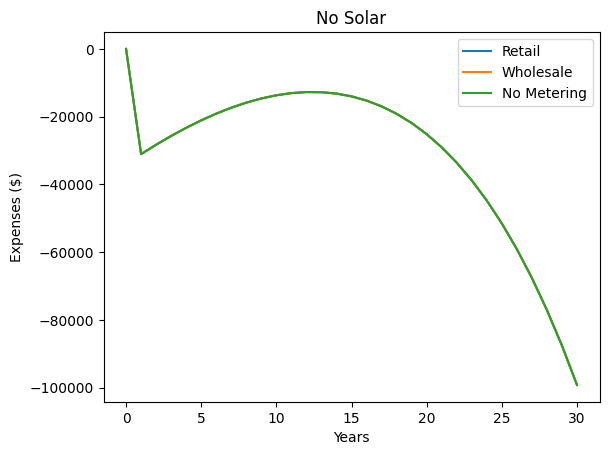

In [38]:
agg_cost_no_solar = [0]
invest_history = [34000]

for i in range(1, years+1):
  invest_gain = invest(invest_history[-1], 0.07, 1)
  agg_cost_no_solar.append(np.sum(hourly_usage) * rate * i - invest_gain)
  invest_history.append(invest_gain)

print(agg_cost_no_solar)

plt.plot(np.arange(0, years+1), agg_cost_no_solar, label="Retail")
plt.plot(np.arange(0, years+1), agg_cost_no_solar, label="Wholesale")
plt.plot(np.arange(0, years+1), agg_cost_no_solar, label="No Metering")
plt.title("No Solar")
plt.xlabel("Years")
plt.ylabel("Expenses ($)")
plt.legend()

This graph shows how the expenses of having no solar panels changes throughout the 30 years. There is only one line because we don't have any solar panels, so the type of net metering does not affect expenses. There appears to be an inflection point around 10-15 years in; this would be the point when the returns from the invested money start becoming more than the money spent on electricity per year.

### **SOLAR ONLY**

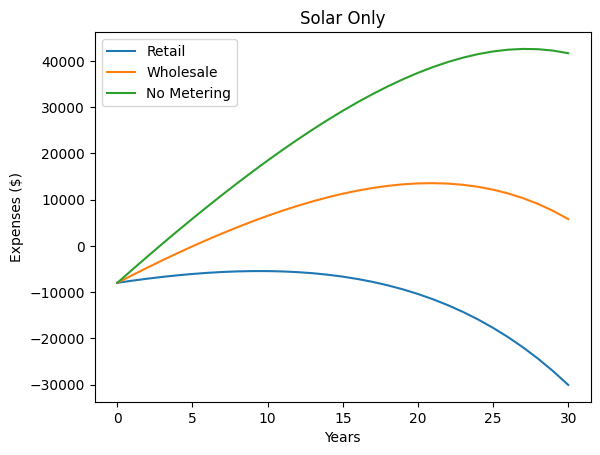

In [23]:
invest_solar = [8000]

for i in range(1, years+1):
  invest_solar.append(invest(invest_solar[-1], 0.07, 1))

# print(invest_solar)
# print(solar_retail)
agg_cost_solar_retail = []
agg_cost_solar_wholesale = []
agg_cost_solar_no_metering = []

solar_retail_30_years = retail_metering_cost(rate, years)
for i, cost in enumerate(invest_solar):
  agg_cost_solar_retail.append((solar_retail_30_years * i/years) - cost)

solar_wholesale_30_years = wholesale_metering_cost(rate, years)
for i, cost in enumerate(invest_solar):
  agg_cost_solar_wholesale.append((solar_wholesale_30_years * i/years) - cost)

solar_no_metering_30_years = no_net_metering_cost(rate, years)
for i, cost in enumerate(invest_solar):
  agg_cost_solar_no_metering.append((solar_no_metering_30_years * i/years) - cost)

plt.plot(np.arange(0, years+1), agg_cost_solar_retail, label="Retail")
plt.plot(np.arange(0, years+1), agg_cost_solar_wholesale, label="Wholesale")
plt.plot(np.arange(0, years+1), agg_cost_solar_no_metering, label="No Metering")
plt.title("Solar Only")
plt.xlabel("Years")
plt.ylabel("Expenses ($)")
plt.legend()

# agg_cost_solar_retail

This graph shows the expenses of installing solar panels over 30 years, with the three lines representing the three different types of net metering. Retail net metering appears to have the lowest expense, which is expected because retail net metering allows the homeowner to make the most money from every kWh of extra electricity generated. The expenses for the other two net metering methods are both positive, but they both appear to start turning around and trending towards negative around 20-30 years in, which means that they could eventually become negative in a longer timeframe.

### **Solar + Battery**

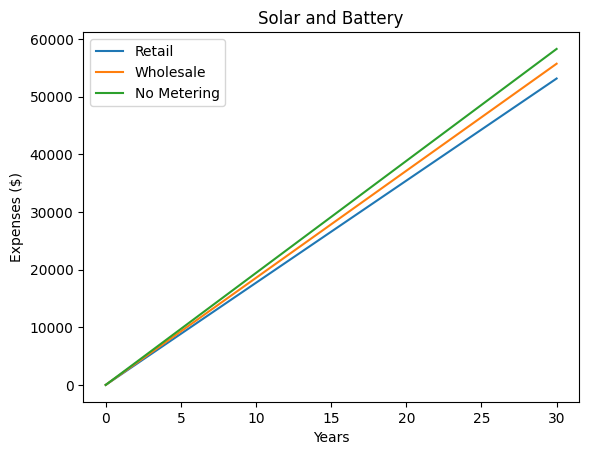

In [24]:
agg_cost_solar_battery_retail = []
agg_cost_solar_battery_wholesale = []
agg_cost_solar_battery_no_metering = []

for i in range(31):
  agg_cost_solar_battery_retail.append(solar_battery_retail * i/years)

for i in range(31):
  agg_cost_solar_battery_wholesale.append(solar_battery_wholesale * i/years)

for i in range(31):
  agg_cost_solar_battery_no_metering.append(solar_battery_no_metering * i/years)

plt.plot(np.arange(0, years+1), agg_cost_solar_battery_retail, label="Retail")
plt.plot(np.arange(0, years+1), agg_cost_solar_battery_wholesale, label="Wholesale")
plt.plot(np.arange(0, years+1), agg_cost_solar_battery_no_metering, label="No Metering")
plt.title("Solar and Battery")
plt.xlabel("Years")
plt.ylabel("Expenses ($)")
plt.legend()


This graph shows the expenses of installing solar panels with a 15 kWh battery over 30 years, with the three lines representing the three different types of net metering. All three lines are linear and increasing because there are no investments in this scenario to offset the costs. Unlike the other scenarios, these will never become negative expenses, so the homeowners should expect to never make any money off of these three scenarios.

In [25]:
def break_even_years(no_solar_cost, solar_cost, upfront_cost):
    return math.ceil(upfront_cost / (no_solar_cost - solar_cost))

In [26]:
# hourly usage in one year
no_solar_cost_per_year = np.sum(hourly_usage) * 0.36

In [27]:
solar_retail_per_year = retail_metering_cost(rate, 1)
solar_wholesale_per_year = wholesale_metering_cost(rate, 1)
solar_no_metering_per_year = no_net_metering_cost(rate, 1)

solar_battery_retail_per_year = retail_metering_cost(rate, 1, battery=True)
solar_battery_wholesale_per_year = wholesale_metering_cost(rate, 1, battery=True)
solar_battery_no_metering_per_year = no_net_metering_cost(rate, 1, battery=True)

In [28]:
solar_retail_years = break_even_years(no_solar_cost_per_year, solar_retail_per_year, 26000)
solar_wholesale_years = break_even_years(no_solar_cost_per_year, solar_wholesale_per_year, 26000)
solar_no_metering_years = break_even_years(no_solar_cost_per_year, solar_no_metering_per_year, 26000)

solar_battery_retail_years = break_even_years(no_solar_cost_per_year, solar_battery_retail_per_year, 34000)
solar_battery_wholesale_years = break_even_years(no_solar_cost_per_year, solar_battery_wholesale_per_year, 34000)
solar_battery_no_metering_years = break_even_years(no_solar_cost_per_year, solar_battery_no_metering_per_year, 34000)

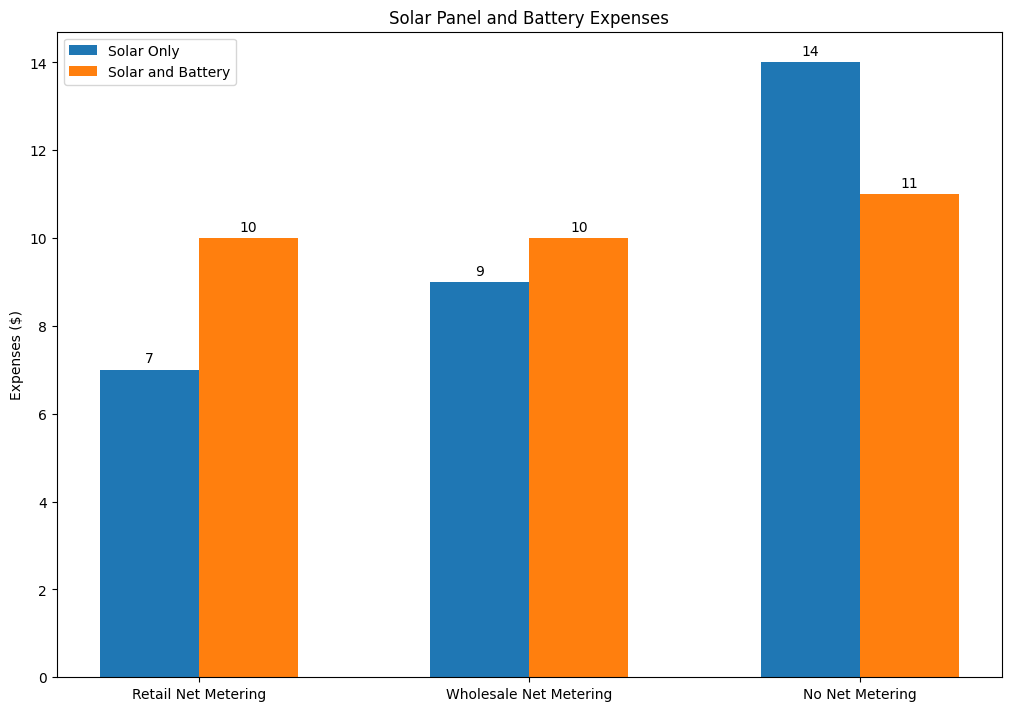

In [29]:
system_type = ("Retail Net Metering", "Wholesale Net Metering", "No Net Metering")
expenses = {
    'Solar Only': (solar_retail_years, solar_wholesale_years, solar_no_metering_years),
    'Solar and Battery': (solar_battery_retail_years, solar_battery_wholesale_years, solar_battery_no_metering_years),
}

x = np.arange(len(system_type))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,7), layout='constrained')

for attribute, measurement in expenses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expenses ($)')
ax.set_title('Solar Panel and Battery Expenses')
ax.set_xticks(x + width/2, system_type)
ax.legend(loc='best')
# ax.set_ylim(0, 250)

plt.show()

This graph shows the number of years it will take for the upfront cost of each scenario to "break even" compared to the cost of electricity without solar panels and without investments. We see that for retail and wholesale net metering, having just solar will break even more quickly compared to solar with battery. The difference is less with wholesale because it is more cost efficient to simply pull electricity from the battery, compared to selling it to the grid and buying it back when you need it; however, this is still not enough to offset the upfront cost of the battery. For no net metering, having a battery will break even more quickly, which makes sense because any additional energy generated by the solar panels is "wasted" (no money is made off of it) when you send it back to the grid.

Once we remove the investments, we can see that all scenarios will break even in reasonable timeframes. Any one of these options would be a good choice for Sam and his family to make, and this investment in solar panels will both benefit the planet and be less volatile compared to investing in something like the stock market.